# Sentiment Analysis Between Communities

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import re

#### Load data, split post properties into columns, create networkx graphs

In [2]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

# separate post properties into different columns
post_colnames_df = pd.read_csv("post_properties_column_names.csv")
col_list = list(post_colnames_df['Colname'].values)
df_full[col_list] = df_full.loc[:,'PROPERTIES'].str.split(',', expand=True)
df_full[col_list] = df_full[col_list].astype(float) # correct datatype

## filter by political subreddits
# read in political subs
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]
regex = re.compile(r'(politic|trump|biden|democrat|republican|liberal|conservative|progressive|socialist|libertarian|election|vote|campaign|maga|antifa|obama|sanders|rights|reform|policy|government|senate|president)', re.IGNORECASE)
dynamic_political_subs = [sub for sub in df_full["SOURCE_SUBREDDIT"].unique() if regex.search(sub)]
political_subs.extend(dynamic_political_subs)

# filter dataframe 
source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)

# keep only connections where both are political
df = df_full[source_is_political & target_is_political]
df_psource = df_full[source_is_political]
df_ptarget = df_full[target_is_political]

# create graphs
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# add link sentiments
df_counts = df.groupby([source, target])['LINK_SENTIMENT'].value_counts().reset_index()
links = df_counts.groupby(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'LINK_SENTIMENT'])['count'].sum().unstack(fill_value=0).reset_index().rename(columns={1: 'POSITIVE', -1: 'NEGATIVE'})
edgelist_df = edgelist_df.merge(links, how='inner', on=[source,target])
edgelist_df["LINK_SENTIMENT"] = edgelist_df["POSITIVE"] - edgelist_df["NEGATIVE"]
G_directed = nx.from_pandas_edgelist(edgelist_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count", "POSITIVE", "NEGATIVE", "LINK_SENTIMENT"])
G_undirected = G_directed.to_undirected()

#### Use Louvain Community Detection

In [3]:
# Compute the best partition
# partition = community_louvain.best_partition(G_undirected, weight='count')
def best_louvain_partition(G):

    best_modularity = -1
    best_partition = None
    for i in range(50):
        partition = community_louvain.best_partition(G, weight='count', random_state=i)
        modularity_value = community_louvain.modularity(partition, G)
        if modularity_value > best_modularity:
            best_modularity = modularity_value
            best_partition = partition
    return best_partition

partition = best_louvain_partition(G_undirected) 

nx.set_node_attributes(G_undirected, partition, 'community')
nx.set_node_attributes(G_directed, partition, 'community')

# transform to list of community sets
partition_df = pd.DataFrame({'subreddit': partition.keys(), 'community':partition.values()})
communities = partition_df.groupby(by='community').agg(set)['subreddit'].tolist()

# Select the top three nodes with the highest degree in each community for labeling
community_labels = {}
for community in set(partition.values()):
    community_nodes = [node for node in partition if partition[node] == community]
    
    top_nodes = sorted(community_nodes, key=lambda node: G_undirected.degree(node), reverse=True)[:3]

    community_labels[community] = top_nodes

# Add communities to dataframe
df["SOURCE_COMMUNITY"] = df['SOURCE_SUBREDDIT'].map(partition)
df["TARGET_COMMUNITY"] = df['TARGET_SUBREDDIT'].map(partition)

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_37469/3334591981.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SOURCE_COMMUNITY"] = df['SOURCE_SUBREDDIT'].map(partition)
/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_37469/3334591981.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TARGET_COMMUNITY"] = df['TARGET_SUBREDDIT'].map(partition)


# Sentiment Analysis
- Sentiment variables:
  - **'LINK_SENTIMENT'** : -1/1 classification of link sentiment
  - **'sentiment_positive'** : VADER positive sentiment of entire post
  - **'sentiment_negative'** : VADER negative sentiment of entire post
  - **'sentiment_compound'** : VADER sentiment of entire post, [-1,1]

## Distributions of post sentiment (VADER)
When looking at the distribution of post sentiments, it appears that political subreddits have a larger proportion of negative posts compared with the full dataset.  The distribution of all posts in the full dataset which hyperlink a political subreddit, it is clear that there is a larger proportion of negative posts linking political subreddits than negative posts in the full dataset or originating from political subreddits.  This could indicate a negative perception of political subreddits from other non-political communities.

### Post sentiments over whole dataset

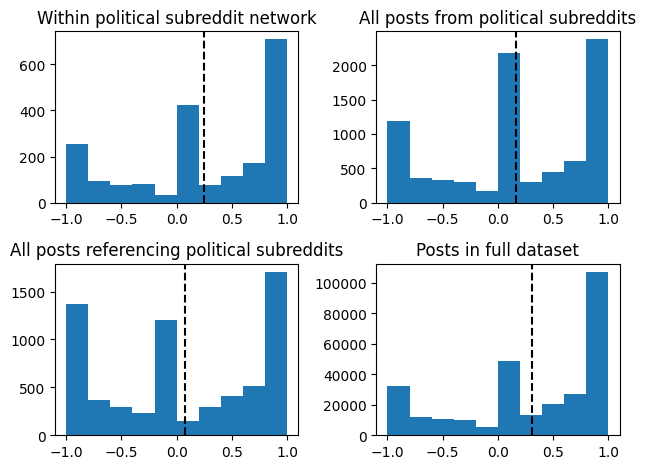

In [4]:
dfs = [df, df_psource, df_ptarget, df_full]

fig, axs = plt.subplots(2,2)

for ax, data in zip(axs.flatten(), dfs):
    ax.hist(data['sentiment_compound'])
    ax.axvline(np.mean(data['sentiment_compound']), linestyle='--', color='black')

axs[0][0].set_title("Within political subreddit network")
axs[0][1].set_title("All posts from political subreddits")
axs[1][0].set_title("All posts referencing political subreddits")
axs[1][1].set_title("Posts in full dataset")

plt.tight_layout()
plt.show()

### Post sentiments by louvain community
**When the political subreddits are the source post:**

Communities with more negative posts in dataset than positive: 
- Community 5 (ukpolitics)
- Community 7 (gunpolitics)
- Community 12 (europes)

Most neutral:
- Community 3 (worldpolitics)

All other communities have majority positive posts. 

----------------------------------------------


**When the political subreddits are the target post:**
- Many of the sentiment distributions shift to be more negative when political subreddits are the ones hyperlinked
- The exception to this are Community 5 and 12 (related to European politics) which show the opposite effect - the distribution shifts to be more positive.

NOTE: these are relatively small sample sizes when dividing by community.

			VADER SENTIMENT BY COMMUNITY 





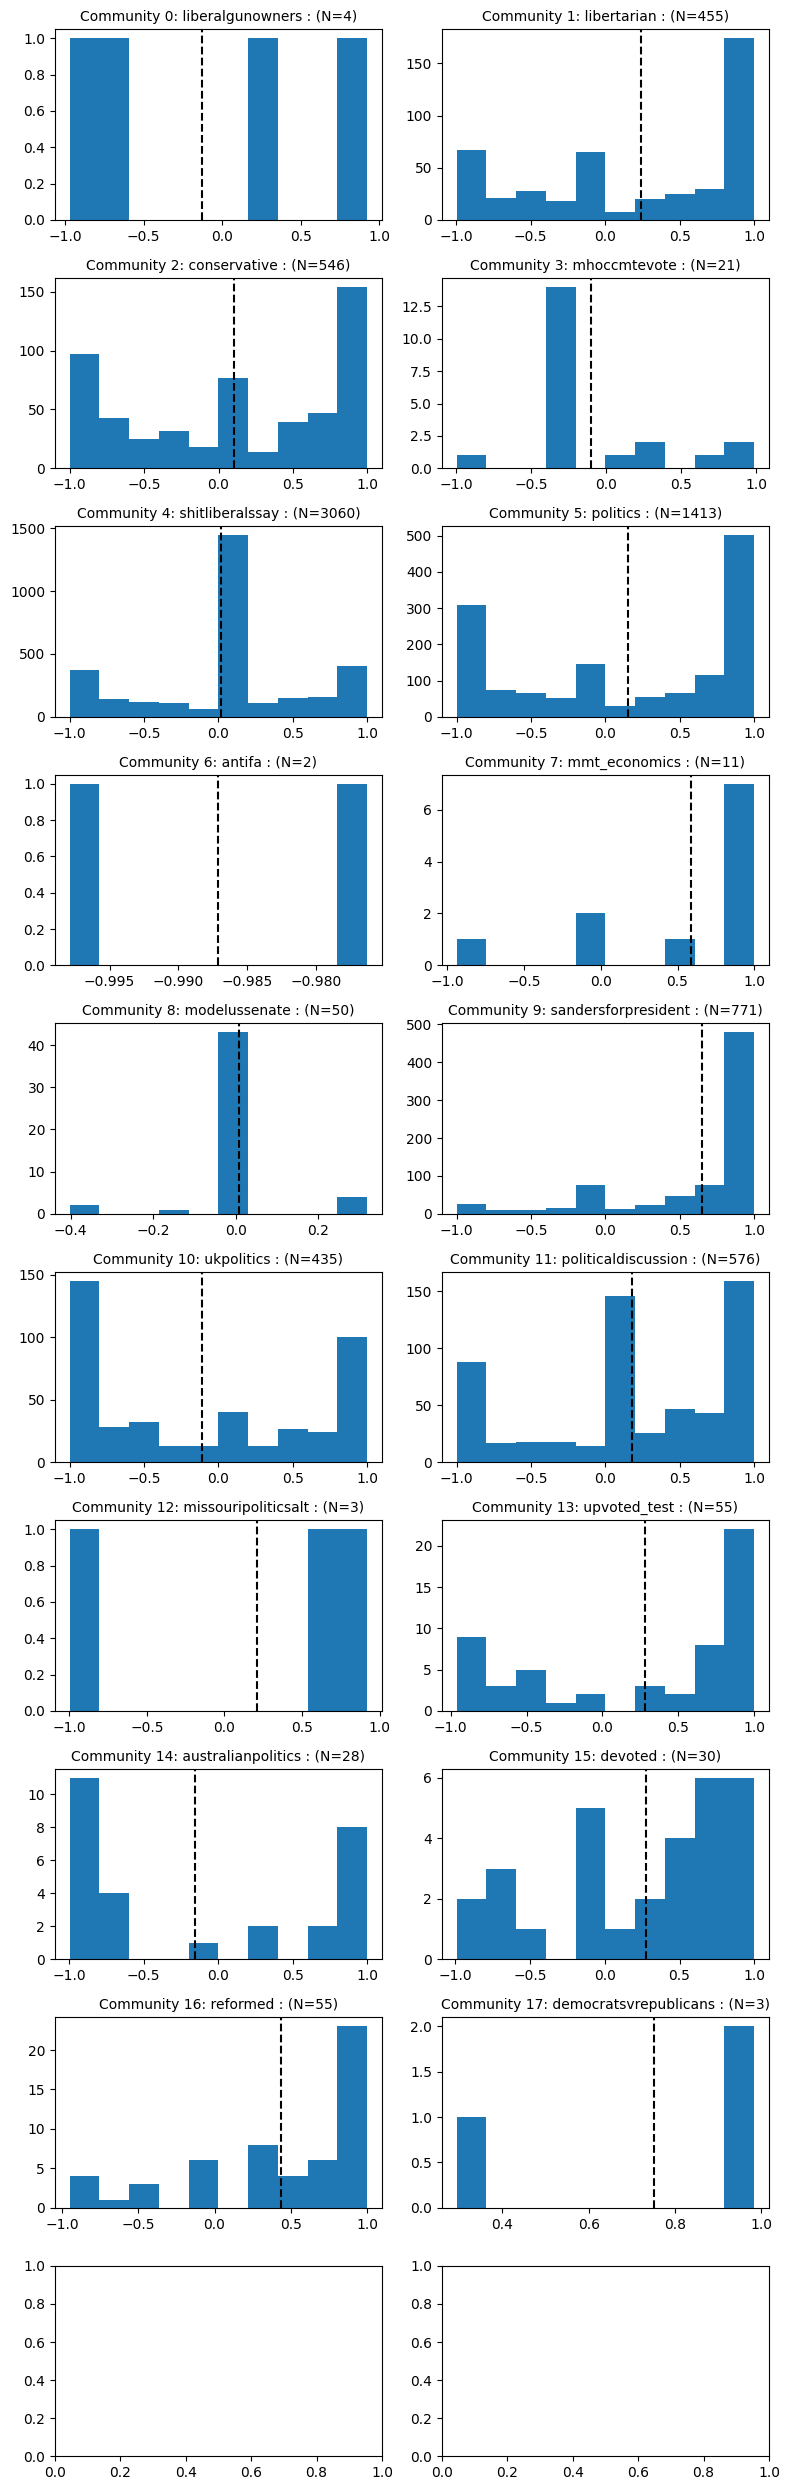

In [5]:
def plot_avg_sentiment(df, sentiment):
    fig, axs = plt.subplots(len(communities)//2 +1,2, figsize=(8,25))
    flat_ax = axs.flatten()
    
    for i, comm in enumerate(communities):
        idx_source = df[source].isin(comm)
        x_source = df[idx_source][f'sentiment_{sentiment}']
        flat_ax[i].hist(x_source)
        flat_ax[i].axvline(np.mean(x_source), linestyle='--', color="black")
        flat_ax[i].set_title(f'Community {i}: {community_labels[i][0]} : (N={len(x_source)})', fontdict={'fontsize': 10})
        ax.set_xlim([-1, 1])

    plt.tight_layout()
    plt.show()
    
print("\t\t\tVADER SENTIMENT BY COMMUNITY \n\n\n")

plot_avg_sentiment(df_full, 'compound')

## Hyperlink sentiments

In [6]:
253/(1780 + 253)
21070/(265491 + 21070)

0.07352710243194294

LINK_SENTIMENT
 1    1780
-1     253
Name: count, dtype: int64 


LINK_SENTIMENT
 1    7040
-1    1195
Name: count, dtype: int64 


LINK_SENTIMENT
 1    5618
-1     933
Name: count, dtype: int64 


LINK_SENTIMENT
 1    265491
-1     21070
Name: count, dtype: int64 




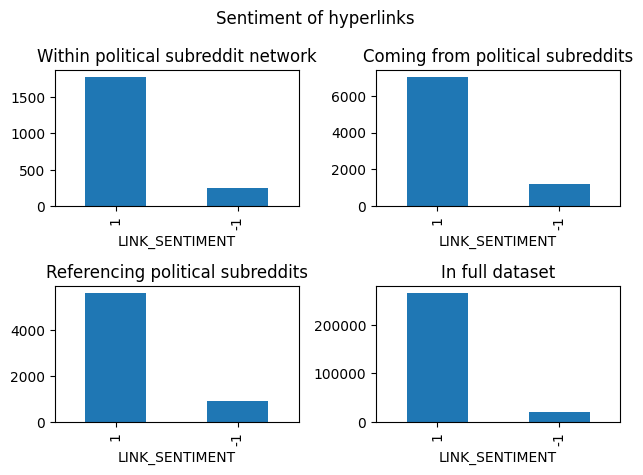

In [7]:
def sentiment_value_counts(df, ax):
    value_counts = df['LINK_SENTIMENT'].value_counts()
    print(value_counts, "\n\n")
    df['LINK_SENTIMENT'].value_counts().plot(kind='bar', ax=ax)
    
fig, axs = plt.subplots(2,2)

for ax, data in zip(axs.flatten(), [df, df_psource, df_ptarget, df_full]):
    sentiment_value_counts(data, ax)

axs[0][0].set_title("Within political subreddit network")
axs[0][1].set_title("Coming from political subreddits")
axs[1][0].set_title("Referencing political subreddits")
axs[1][1].set_title("In full dataset")
plt.suptitle("Sentiment of hyperlinks")
plt.tight_layout()
plt.show()

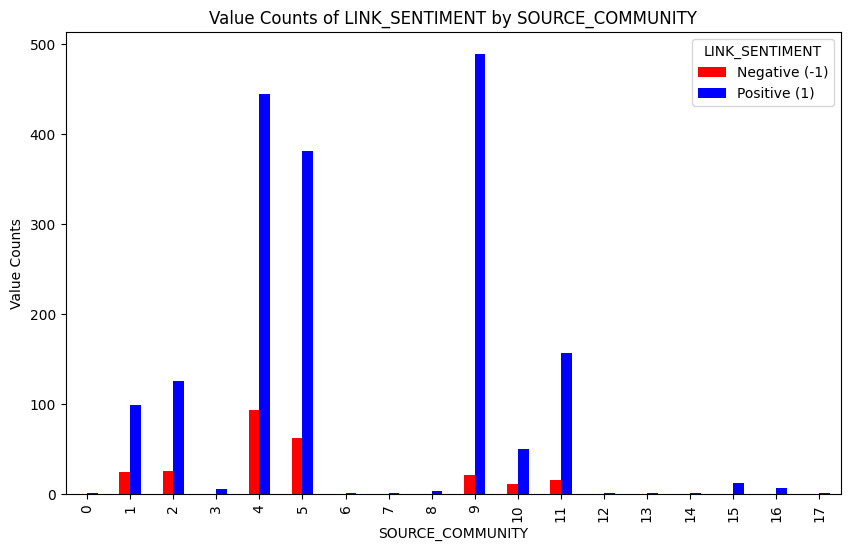

In [8]:
temp = df.groupby(by='SOURCE_COMMUNITY')['LINK_SENTIMENT'].value_counts()

temp = pd.Series(temp).unstack().fillna(0)  # Unstack to get LINK_SENTIMENT in columns
temp.index = temp.index.astype(int)  # Convert index to integers for sorting
temp = temp.sort_index()  # Sort by SOURCE_COMMUNITY for a cleaner plot
temp.plot(kind='bar', stacked=False, color=['red', 'blue'], figsize=(10, 6))
plt.xlabel('SOURCE_COMMUNITY')
plt.ylabel('Value Counts')
plt.title('Value Counts of LINK_SENTIMENT by SOURCE_COMMUNITY')
plt.legend(title='LINK_SENTIMENT', labels=['Negative (-1)', 'Positive (1)'])
plt.show()

## Networks by sentiment

### Political network graph

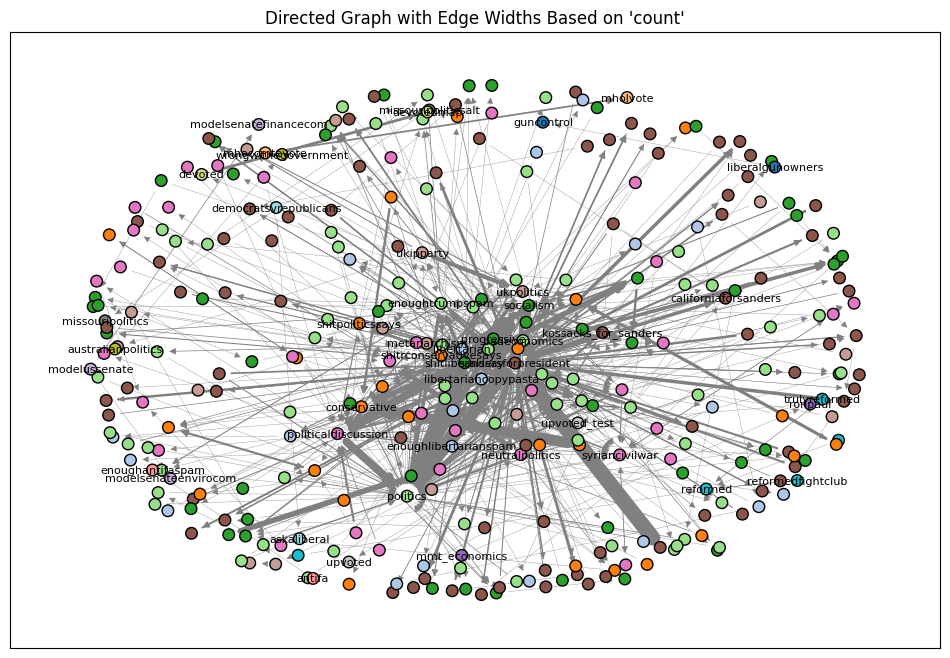

In [9]:
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
nodes = G_undirected.nodes()
node_color_list = [colors(G_undirected.nodes[n]['community']) for n in nodes]

pos = nx.spring_layout(G_directed, seed=42, k=0.5, scale=40)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_directed, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_directed, label_pos, 
                        labels={node: node for node in sum(community_labels.values(),[])},
                        font_size=8, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_directed.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_directed, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Directed Graph with Edge Widths Based on 'count'")
plt.show()

### Network of Negative Hyperlinks in Political Graph

In [10]:
# create graph from political network with negative edges
edgelist = df.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
negative_edges = edgelist[edgelist['LINK_SENTIMENT'] == -1]
negative_edges_df = negative_edges.drop_duplicates().copy()
negative_edges_df["count"] = negative_edges.groupby([source, target]).transform("size")
G_negative_edges = nx.from_pandas_edgelist(negative_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

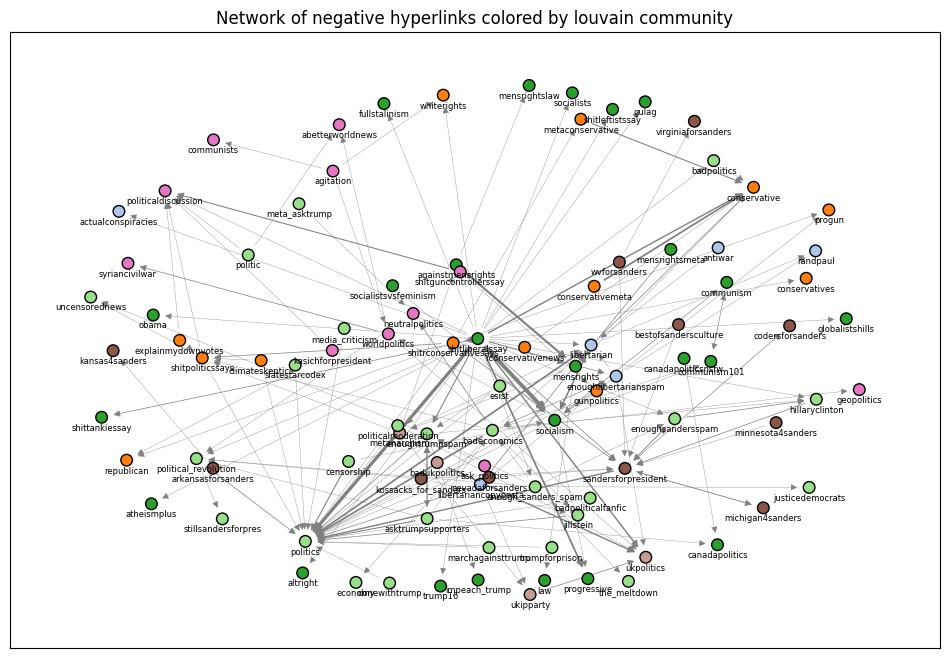

In [11]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_negative_edges.nodes()]

pos = nx.spring_layout(G_negative_edges, seed=42, k=0.5, scale=8)
label_pos = {node: (x, y - 0.3) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_negative_edges, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_negative_edges, label_pos, 
                        labels={node: node for node in G_negative_edges.nodes},
                        font_size=6, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_negative_edges.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_negative_edges, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Network of negative hyperlinks colored by louvain community")
plt.show()

### Network of positive hyperlinks in political network graph

In [12]:
# create graph from political network with positive edges
edgelist = df.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
positive_edges = edgelist[edgelist['LINK_SENTIMENT'] == 1]
positive_edges_df = positive_edges.drop_duplicates().copy()
positive_edges_df["count"] = positive_edges.groupby([source, target]).transform("size")
G_positive_edges = nx.from_pandas_edgelist(positive_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

In [13]:
top_pos_df = edgelist_df.sort_values("POSITIVE", ascending=False).iloc[:50,:]
most_connected = set(np.hstack((top_pos_df[source].unique(),top_pos_df[target].unique())))

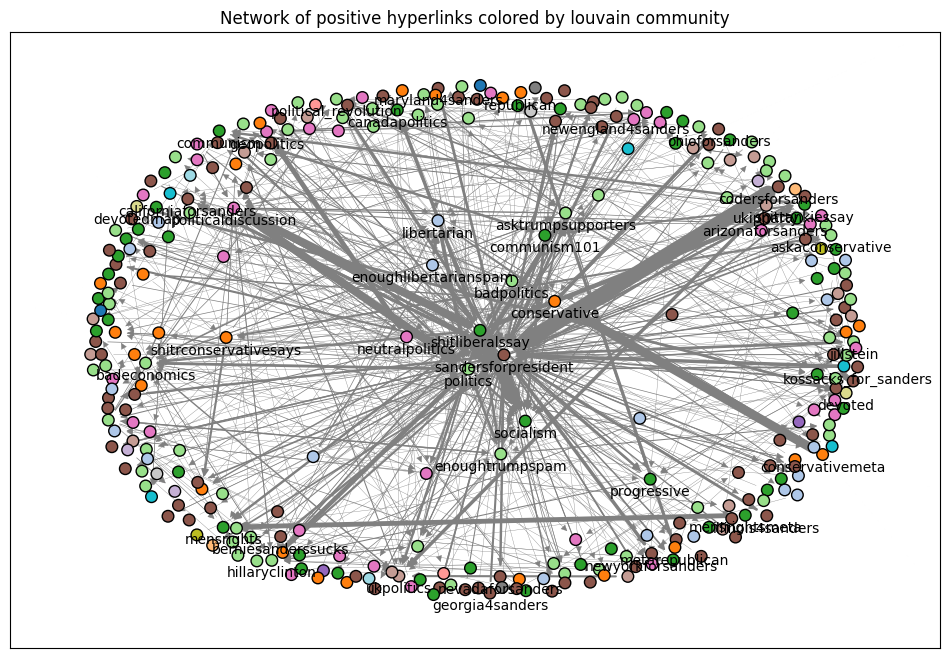

In [14]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_positive_edges.nodes()]

top_pos_df = edgelist_df.sort_values("POSITIVE", ascending=False).iloc[:50,:]
most_connected = set(np.hstack((top_pos_df[source].unique(),top_pos_df[target].unique())))

pos = nx.spring_layout(G_positive_edges, seed=42, k=1.2, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_positive_edges, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_positive_edges, label_pos, 
                        labels={node: node for node in most_connected},
                        font_size=10, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_positive_edges.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_positive_edges, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Network of positive hyperlinks colored by louvain community")
plt.show()

### Network with all negative hyperlinks targeting political subs

In [15]:
# create graph from subreddits negatively linking a political sub
edgelist = df_ptarget.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
negative_edges = edgelist[edgelist['LINK_SENTIMENT'] == -1]
negative_edges_df = negative_edges.drop_duplicates().copy()
negative_edges_df["count"] = negative_edges.groupby([source, target]).transform("size")
G_nt = nx.from_pandas_edgelist(negative_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

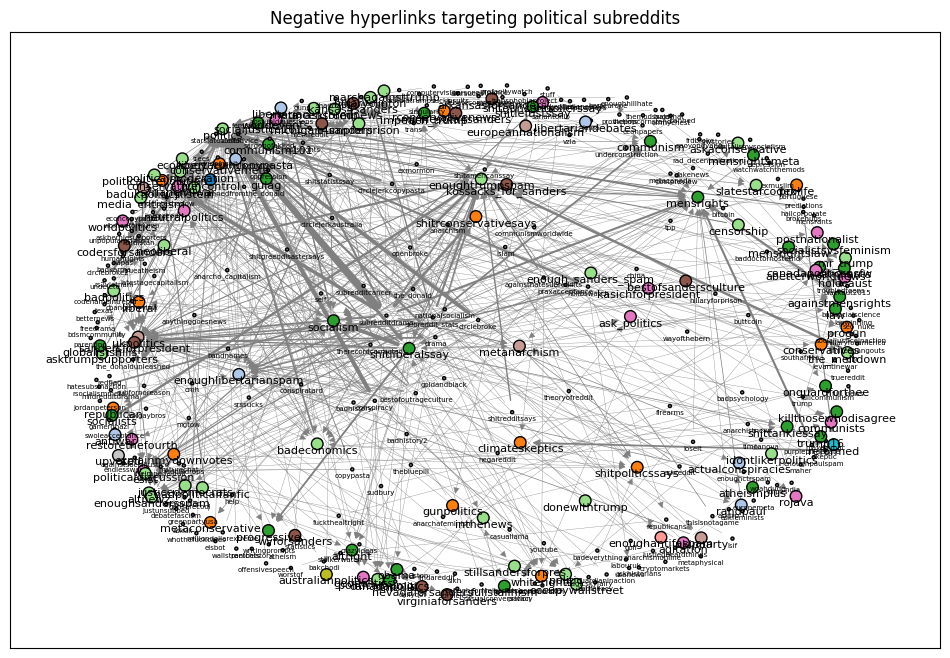

In [16]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_nt.nodes()]

node_sizes = [5 if color == 'grey' else 70 for color in node_color_list]
font_sizes = [5 if color == 'grey' else 8 for color in node_color_list]

pos = nx.spring_layout(G_nt, seed=42, k=0.8, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_nt, pos, node_size=node_sizes, node_color=node_color_list, edgecolors="black")
# Define the positions and labels
labels = {node: node for node in G_nt.nodes()}

# Loop over nodes and draw each label with the appropriate font size
for i, (node, (x, y)) in enumerate(pos.items()):
    # Set font size based on node size
    font_size = 5 if node_sizes[i] == 5 else 8
    plt.text(x, y - 0.05, labels[node], fontsize=font_size, ha='center', va='center', color="black")
##

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_nt.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_nt, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Negative hyperlinks targeting political subreddits")
plt.show()

### Network with all positive hyperlinks targeting political subs

In [17]:
# create graph from subreddits positively linking a political sub
edgelist = df_ptarget.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
positive_edges = edgelist[edgelist['LINK_SENTIMENT'] == 1]
positive_edges_df = positive_edges.drop_duplicates().copy()
positive_edges_df["count"] = positive_edges.groupby([source, target]).transform("size")
G_pt = nx.from_pandas_edgelist(positive_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

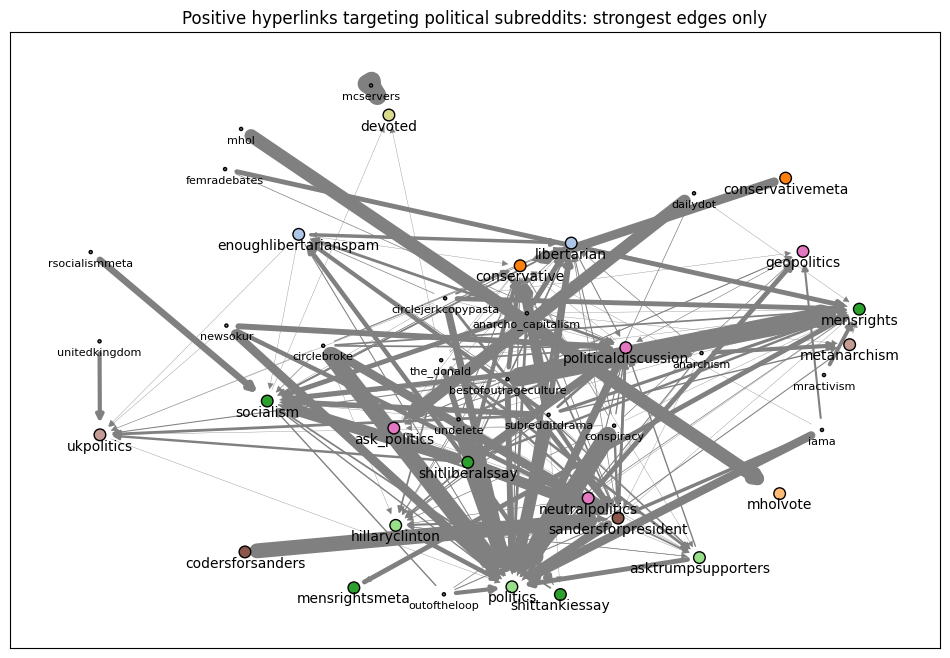

In [18]:
# Set up the plot
plt.figure(figsize=(12, 8))

# Define colors
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i)

# Filter out grey nodes (i.e., only keep nodes in the communities)
non_grey_nodes = [node for node in G_pt.nodes() if node in node_colors]

threshold = 10 
strong_edges = [(u, v, d) for u, v, d in G_pt.edges(data=True) if d['count'] > threshold]
strong_nodes = list(pd.DataFrame(strong_edges).drop(columns=2).stack().unique())

# Create a new graph with only the non-grey nodes and strong edges
G_filtered = G_pt.subgraph(strong_nodes).copy()
G_filtered.add_edges_from(strong_edges)

# Recompute positions for the filtered graph
pos = nx.spring_layout(G_filtered, seed=42, k=1.5, scale=5)

# Assign node colors and sizes for the filtered graph
node_color_list = [node_colors.get(node, 'grey') for node in G_filtered.nodes()]
node_sizes = [5 if color == 'grey' else 70 for color in node_color_list]
font_sizes = [5 if color == 'grey' else 8 for color in node_color_list]

# Define the positions and labels
labels = {node: node for node in G_filtered.nodes()}

# Draw nodes with community colors
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color=node_color_list, edgecolors="black")

# Loop over nodes and draw each label with the appropriate font size
for i, (node, (x, y)) in enumerate(pos.items()):
    font_size = 8 if node_sizes[i] == 5 else 10
    plt.text(x, y - 0.2, labels[node], fontsize=font_size, ha='center', va='center', color="black")

# Edge widths related to count attribute (in the filtered graph)
edge_widths = [d['count'] / 4 for (_, _, d) in G_filtered.edges(data=True)]

# Draw edges with widths based on count
nx.draw_networkx_edges(G_filtered, pos, edge_color="gray", arrows=True, width=edge_widths)

# Set title and show plot
plt.title("Positive hyperlinks targeting political subreddits: strongest edges only")
plt.show()


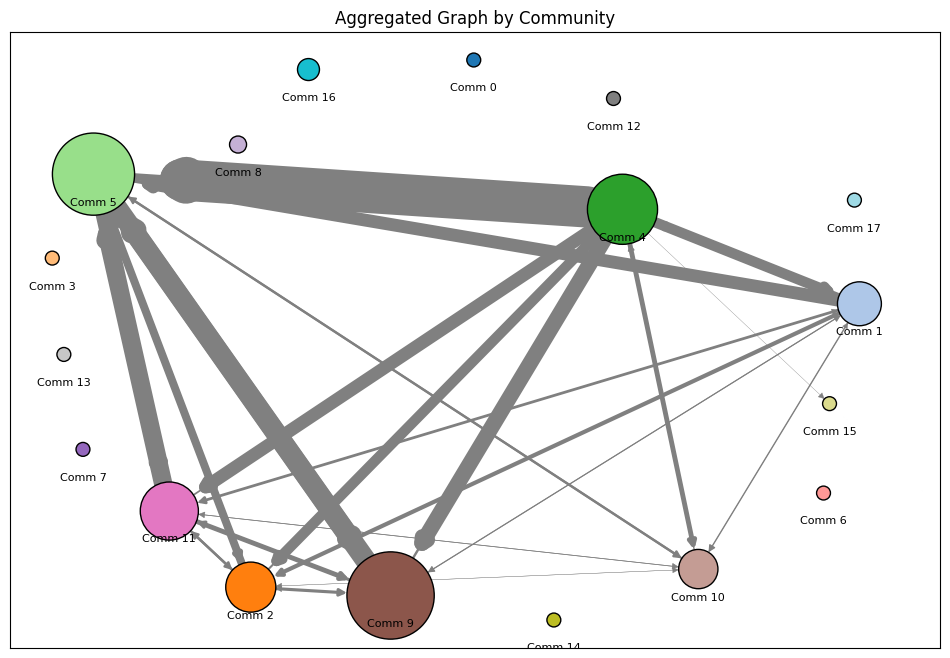

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph for aggregated communities
G_aggregated = nx.DiGraph()

# Map each node to its community index
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Add aggregated nodes (one for each community)
for i in range(len(communities)):
    G_aggregated.add_node(i, size=len(communities[i]))

# Aggregate edges between communities
for u, v, data in G_directed.edges(data=True):
    weight = data.get('count', 1)  # Default to 1 if 'count' not specified
    u_comm = node_to_community[u]
    v_comm = node_to_community[v]
    if u_comm != v_comm:  # Ignore intra-community edges
        if G_aggregated.has_edge(u_comm, v_comm):
            G_aggregated[u_comm][v_comm]['weight'] += weight
        else:
            G_aggregated.add_edge(u_comm, v_comm, weight=weight)

# Visualize the aggregated graph
plt.figure(figsize=(12, 8))

# Define node colors and sizes
colors = plt.get_cmap('tab20', len(communities))
node_colors = [colors(i) for i in range(len(communities))]
node_sizes = [G_aggregated.nodes[n]['size'] * 50 for n in G_aggregated.nodes()]

# Define edge widths based on weights
edge_widths = [d['weight'] / 4 for (_, _, d) in G_aggregated.edges(data=True)]

# Layout and draw the graph
pos = nx.spring_layout(G_aggregated, seed=42, k=10, scale=1)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_aggregated, pos, node_size=node_sizes, node_color=node_colors, edgecolors="black")
nx.draw_networkx_labels(G_aggregated, label_pos, 
                        labels={node: f"Comm {node}" for node in G_aggregated.nodes()},
                        font_size=8, font_color="black")
nx.draw_networkx_edges(G_aggregated, pos, node_size=node_sizes, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Aggregated Graph by Community")
plt.show()


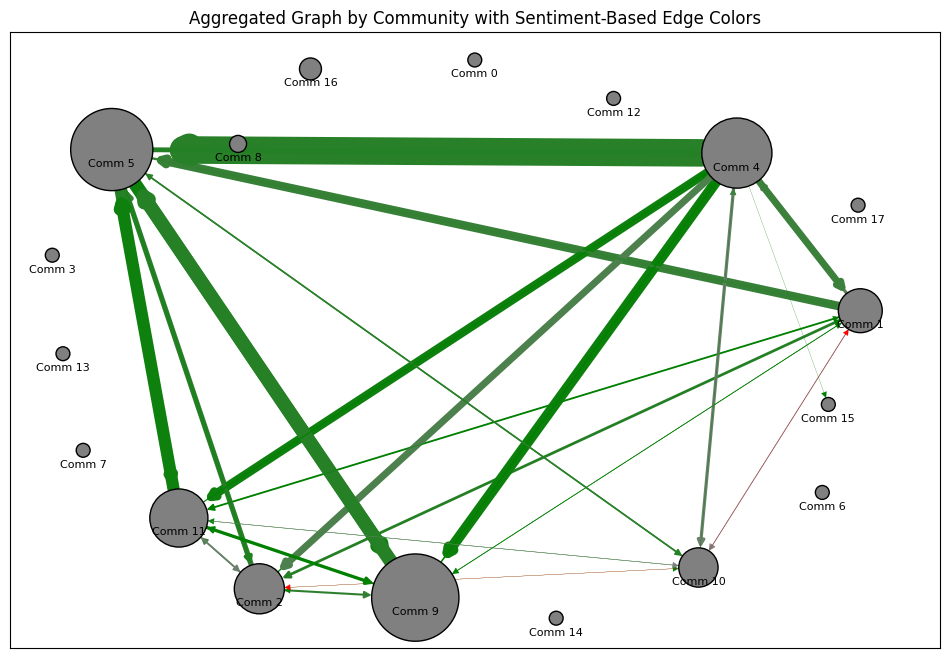

In [20]:
import matplotlib.colors as mcolors

# Create a new graph for aggregated communities
G_aggregated = nx.DiGraph()

for i in range(len(communities)):
    G_aggregated.add_node(i, size=len(communities[i]))

# Aggregate edges between communities, tracking positive/negative sentiment
for u, v, data in G_directed.edges(data=True):
    u_comm = G_directed.nodes[u]['community']
    v_comm = G_directed.nodes[v]['community']
    if u_comm != v_comm:  
        if not G_aggregated.has_edge(u_comm, v_comm):
            G_aggregated.add_edge(u_comm, v_comm, positive=0, negative=0)
        G_aggregated[u_comm][v_comm]['positive'] += data.get('POSITIVE', 0)
        G_aggregated[u_comm][v_comm]['negative'] += data.get('NEGATIVE', 0)

# Calculate the ratio of positive to negative links and assign colors
edge_colors = []
edge_widths = []

for u, v, data in G_aggregated.edges(data=True):
    positive = data['positive']
    negative = data['negative']
    total = positive + negative
    ratio = (positive - negative) / total if total > 0 else 0

    color = mcolors.to_hex(mcolors.LinearSegmentedColormap.from_list(
            "sentiment_scale", [(0, "red"), (0.5, "gray"), (1, "green")]
        )((ratio + 1) / 2)) 
    edge_colors.append(color)

    edge_widths.append(total / 6)

plt.figure(figsize=(12, 8))

# colors = plt.get_cmap('tab20', len(communities))
# node_colors = [colors(i) for i in range(len(communities))]
node_sizes = [G_aggregated.nodes[n]['size'] * 50 for n in G_aggregated.nodes()]

pos = nx.spring_layout(G_aggregated, seed=42, k=10, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_aggregated, pos, node_size=node_sizes, node_color="gray", edgecolors="black")
nx.draw_networkx_labels(G_aggregated, label_pos, 
                        labels={node: f"Comm {node}" for node in G_aggregated.nodes()},
                        font_size=8, font_color="black")
nx.draw_networkx_edges(G_aggregated, pos, node_size=node_sizes, edge_color=edge_colors, arrows=True, width=edge_widths)

plt.title("Aggregated Graph by Community with Sentiment-Based Edge Colors")
plt.show()

## Sentiment metrics

In [21]:
# MOST NEGATIVE LINKS: TARGET
idx_negative = df['LINK_SENTIMENT'] == -1
df.loc[idx_negative, [target, "LINK_SENTIMENT"]].value_counts(target)[:10]

TARGET_SUBREDDIT
politics               53
socialism              19
conservative           17
sandersforpresident    14
ukpolitics             13
mensrights             10
libertarian             9
enoughtrumpspam         9
politicaldiscussion     8
shitpoliticssays        6
Name: count, dtype: int64

In [22]:
# MOST POSITIVE LINKS: TARGET
idx_positive = df['LINK_SENTIMENT'] == 1
df.loc[idx_positive, [target, "LINK_SENTIMENT"]].value_counts(target)[:10]

TARGET_SUBREDDIT
sandersforpresident     405
politics                277
socialism                86
politicaldiscussion      85
conservative             72
libertarian              38
ukpolitics               35
hillaryclinton           29
geopolitics              28
political_revolution     27
Name: count, dtype: int64

In [23]:
# MOST NEGATIVE LINKS: SOURCE
idx_negative = df['LINK_SENTIMENT'] == -1
df.loc[idx_negative, [source, "LINK_SENTIMENT"]].value_counts(source)[:10]

SOURCE_SUBREDDIT
shitliberalssay          66
badeconomics             13
libertarian              12
asktrumpsupporters        9
sandersforpresident       9
socialism                 8
shitrconservativesays     8
againstmensrights         7
libertariancopypasta      6
enoughtrumpspam           6
Name: count, dtype: int64

In [24]:
# MOST POSITIVE LINKS: SOURCE
idx_positive = df['LINK_SENTIMENT'] == 1
df.loc[idx_positive, [source, "LINK_SENTIMENT"]].value_counts(source)[:10]

SOURCE_SUBREDDIT
shitliberalssay        273
sandersforpresident    160
asktrumpsupporters      45
codersforsanders        44
politicaldiscussion     42
libertarian             40
badeconomics            36
enoughtrumpspam         35
socialism               33
neutralpolitics         30
Name: count, dtype: int64

In [25]:
community_labels

{0: ['liberalgunowners', 'guncontrol'],
 1: ['libertarian', 'enoughlibertarianspam', 'libertariancopypasta'],
 2: ['conservative', 'shitrconservativesays', 'shitpoliticssays'],
 3: ['mhoccmtevote', 'mholvote'],
 4: ['shitliberalssay', 'socialism', 'progressive'],
 5: ['politics', 'enoughtrumpspam', 'badeconomics'],
 6: ['antifa', 'enoughantifaspam'],
 7: ['mmt_economics', 'ronpaul'],
 8: ['modelussenate', 'modelsenateenvirocom', 'modelsenatefinancecom'],
 9: ['sandersforpresident', 'kossacks_for_sanders', 'californiaforsanders'],
 10: ['ukpolitics', 'metanarchism', 'ukipparty'],
 11: ['politicaldiscussion', 'syriancivilwar', 'neutralpolitics'],
 12: ['missouripoliticsalt', 'missouripolitics'],
 13: ['upvoted_test', 'upvoted'],
 14: ['australianpolitics', 'wrongwithegovernment'],
 15: ['devoted', 'devotedmap'],
 16: ['reformed', 'trulyreformed', 'reformedfightclub'],
 17: ['democratsvrepublicans', 'askaliberal']}

In [26]:
# NUMBER OF LINKS BETWEEN COMMUNITIES
df[['SOURCE_COMMUNITY','TARGET_COMMUNITY']].value_counts().reset_index()

,SOURCE_COMMUNITY,TARGET_COMMUNITY,count
0,9,9,430
1,5,5,290
2,4,4,261
3,4,5,119
4,2,2,105
5,11,11,90
6,9,5,60
7,5,9,58
8,11,5,53
9,10,10,47


In [27]:
communities

[{'guncontrol', 'liberalgunowners'},
 {'acteuropa',
  'actualconspiracies',
  'antiwar',
  'austrian_economics',
  'calibertarians',
  'classicalliberal',
  'classicalliberalparty',
  'demsocialist',
  'enoughlibertarianspam',
  'libertarian',
  'libertariancopypasta',
  'libertariandebates',
  'libertarianmeme',
  'libertarianpartyohio',
  'libertarianpartyusa',
  'magajuana',
  'newjerseylibertarians',
  'randpaul',
  'shitlibertariansay',
  'theredpillright'},
 {'climateskeptics',
  'conservative',
  'conservativemeta',
  'conservatives',
  'conservatives_r_us',
  'conservativesonly',
  'daverubin',
  'explainmydownvotes',
  'georgism',
  'gunpolitics',
  'isrconservativeracist',
  'liberal',
  'metaconservative',
  'metarepublican',
  'nevertrump',
  'new_right',
  'paleoconservative',
  'prochoice',
  'progun',
  'prolife',
  'rconservativenews',
  'republican',
  'shitpoliticssays',
  'shitrconservativesays',
  'thedavidpakmanshow',
  'whiterights'},
 {'mhoccmtevote', 'mholvote'}